In [1]:
import sys
sys.path.append('./code')
sys.path.append('./data')

import gillespy2
from clustering import *
from MISA import *
from joblib import Parallel, delayed
from sklearn.cluster import KMeans

# from https://github.com/eepperly/Randomly-Pivoted-Cholesky
from rpcholesky import rpcholesky
from matrix import KernelMatrix

np.random.seed(1)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['axes.linewidth'] = 1.25

2024-05-27 23:14:44,687 - GillesPy2 - WARNING - Unable to use C++ optimized solvers due to one or more missing dependencies: ['g++']. The performance of this package can be significantly increased if you install/configure these on your machine.


In [2]:
def one_MISA_test(nSims,nT, Tmax, param1,param2):

    nT = int(nT)
    nSims = int(nSims)
    trajs1 = np.zeros([nSims,nT,2])
    trajs2 = np.zeros([nSims,nT,2])
    for i in range(0,nSims):
        model1 = create_MISA_model_numpy(end_time=Tmax,nSamples=int(nT),frval=param1, astart=np.random.randint(0,100),bstart=np.random.randint(0,100))
        ssa_solver1 = gillespy2.NumPySSASolver(model=model1)
        results= model1.run(solver=ssa_solver1)

        trajs1[i,:,0] = results['a'][0:nT]
        trajs1[i,:,1] = results['b'][0:nT]

        model2 = create_MISA_model_numpy(end_time=Tmax,nSamples=int(nT),frval=param2, astart=np.random.randint(0,100),bstart=np.random.randint(0,100))
        ssa_solver2 = gillespy2.NumPySSASolver(model=model2)
        results2= model2.run(solver=ssa_solver2)

        trajs2[i,range(0,nT),0] = results2['a'][0:nT]
        trajs2[i,range(0,nT),1] = results2['b'][0:nT]  
        trajs2[i,range(0,nT),0] = results2['a'][0:nT]
        trajs2[i,range(0,nT),1] = results2['b'][0:nT]   
    trajs = np.concatenate([trajs1,trajs2]) # 2nSims x nT x 2
    flattened_traj = np.reshape(trajs,[2*nSims*nT,2])



    ### cluster
    lra = rpcholesky(KernelMatrix(flattened_traj,bandwidth=50),100)
    F = lra.get_right_factor()
    idx = lra.get_indices()
        
    # dense eigensolver
    normal = F.T @ (F @ np.ones(F.shape[1]))
    normal[normal > 0] = normal[normal > 0]**-.5
    F = F * normal[np.newaxis, :]
    vals, vecs = np.linalg.svd(F, full_matrices=False)[1:3]
    vecs = vecs.T * normal[:, np.newaxis]
    v_min =5
    V = vecs[:, 0:v_min]

    # k-means clustering
    nClusters = 4
    kmeans = KMeans(n_clusters=nClusters,n_init='auto').fit(V)


    # now do VEM
    discrete_trajs = np.reshape(kmeans.labels_,[2*nSims,nT]).astype('int64')
    Xt= discrete_trajs
    nStates=4
    nEM = 1000
    nClustMax=2

    zHat, muHat, qHat, pHat, steps, logL = doVEMmulti(Xt, nClustMax, nStates,nEM=nEM)

    trueLabels = np.zeros(2*nSims,)
    trueLabels[0:nSims] = 0
    trueLabels[nSims:] = 1
    trueLabels= np.ndarray.astype(trueLabels,'int')

    best_assignment, zHat_c, qHat_c, muHat_c, pHat_c = find_best_clustermatch(trueLabels.T, zHat, muHat, qHat, pHat)  # uses HUNGARIAN ALGORITHM to assign best permutation

    predictLabels = zHat_c.argmax(axis=1)

    acc = sum(predictLabels==trueLabels)/(2*nSims)
    return acc

In [3]:
param1=0.01
nTvals=5
nPvals=13
nTrials=100
nSims=15

Tvals = np.round(np.logspace(np.log10(5),2, nTvals))
param2vals = np.logspace(np.log10(param1),np.log10(param1)+2,nPvals)
trialRange = range(nTrials)
    
errVals = np.zeros([nTrials,nTvals,nPvals])


In [4]:

for p in range(nPvals):
    param2 = param2vals[p]
    for t in range(nTvals):
        nT = Tvals[t]
        print([param2,nT])
        outpar = Parallel(n_jobs=-1)(delayed(one_MISA_test)(nSims,nT,nT,param1,param2) for s in trialRange)
        for s in trialRange:
            errVals[s,t,p] = outpar[s]


[0.01, 5.0]
[0.01, 11.0]
[0.01, 22.0]
[0.01, 47.0]
[0.01, 100.0]
[0.014677992676220698, 5.0]
[0.014677992676220698, 11.0]
[0.014677992676220698, 22.0]
[0.014677992676220698, 47.0]
[0.014677992676220698, 100.0]
[0.021544346900318832, 5.0]
[0.021544346900318832, 11.0]
[0.021544346900318832, 22.0]
[0.021544346900318832, 47.0]
[0.021544346900318832, 100.0]
[0.03162277660168379, 5.0]
[0.03162277660168379, 11.0]
[0.03162277660168379, 22.0]
[0.03162277660168379, 47.0]
[0.03162277660168379, 100.0]
[0.046415888336127774, 5.0]
[0.046415888336127774, 11.0]
[0.046415888336127774, 22.0]
[0.046415888336127774, 47.0]
[0.046415888336127774, 100.0]
[0.06812920690579612, 5.0]
[0.06812920690579612, 11.0]
[0.06812920690579612, 22.0]
[0.06812920690579612, 47.0]
[0.06812920690579612, 100.0]
[0.1, 5.0]
[0.1, 11.0]
[0.1, 22.0]
[0.1, 47.0]
[0.1, 100.0]
[0.1467799267622069, 5.0]
[0.1467799267622069, 11.0]
[0.1467799267622069, 22.0]
[0.1467799267622069, 47.0]
[0.1467799267622069, 100.0]
[0.21544346900318834, 5.0

In [5]:
with open('temp/gene_sweep_2024.npy', 'wb') as f:
    np.save(f, param2vals)
    np.save(f, Tvals)
    np.save(f, errVals)
    np.save(f, param1)
    np.save(f, nSims)
    np.save(f, nTrials)


In [6]:
err_means = np.mean(errVals,axis=0)

C:\Users\Chris\AppData\Local\Temp\ipykernel_10232\448817778.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('plasma', 5)    # 5 discrete colors
C:\Users\Chris\AppData\Local\Temp\ipykernel_10232\448817778.py:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=fig.colorbar(sm,ticks=[5, 10, 50, 100])


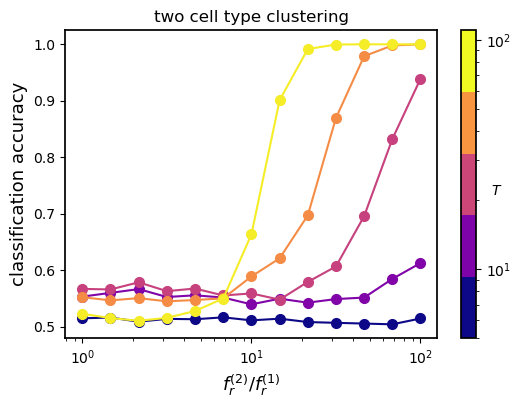

In [7]:
from matplotlib import cm
import matplotlib

norm = matplotlib.colors.LogNorm(vmin=Tvals[0], vmax=Tvals[-1]*1.1)
#import cmcrameri.cm as cmc

fig, ax = plt.subplots(figsize=(6,4)) 
ax.set_xscale('log')


for t in range(nTvals):
    ax.plot(param2vals/param1, err_means[t,:],color=cm.plasma(norm(Tvals[t])),linewidth=1.5,marker='o',markersize=7)

ax.set_xlabel('$f_r^{(2)}/f_r^{(1)}$',fontsize=13)
ax.set_ylabel('classification accuracy',fontsize=13)
ax.set_title('two cell type clustering',fontsize=12)


cmap = cm.get_cmap('plasma', 5)    # 5 discrete colors


sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar=fig.colorbar(sm,ticks=[5, 10, 50, 100])
cbar.set_label('$T$',rotation=0,labelpad=-10)
cbar.set_ticks([10,100])

fig.savefig('figs/gene_clustering_acc.pdf')